In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Lorenz Series

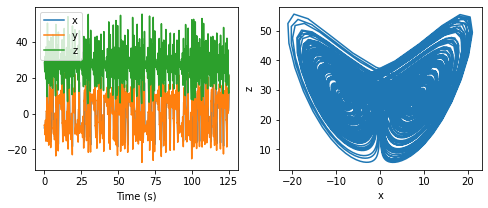

In [3]:
# ======================
# SIGNAL PARAMETERS
# ======================

T = 125 # s, duration of time series
dt = 0.02 # s, time step

initial_condition = (-8.01304744, -6.58865759, 28.60202532)

lorenz_pts = simulate_lorenz(dt=dt, T=T, initial_condition=initial_condition)

time_vals = np.arange(len(lorenz_pts))*dt
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

In [4]:
# ======================
# RESERVOIR PARAMETERS
# ======================

D_r = 300 # number of reservoir nodes
# D_r = 2000 
d = 6 # average degree of Erdos-Renyi network
p = None # probability of an edge in the Erdos-Renyi network - if not None, overrides d
# p = 0.02
rho = 1.2 # spectral radius of the adjacency matrix
# rho = 0.9

beta = 0 # regularization parameter
sigma = 0.1 # maximum value of the input weights

squared_inds = None

var_names = ['x', 'y', 'z']

In [5]:
reservoir = ReservoirDS(lorenz_pts, dt=dt, D_r=D_r, d=d, p=p, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)
reservoir.train_and_test()

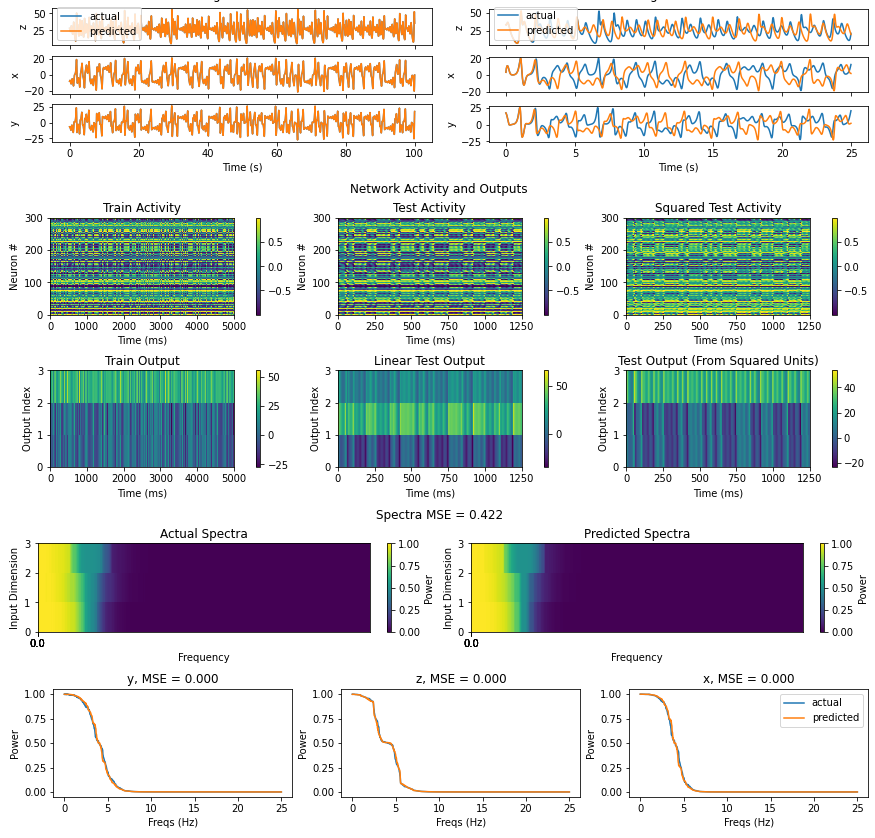

In [6]:
reservoir.plot_all()

In [7]:
reservoir.compute_lyap_spectrum_QR(debug=True)
print(reservoir.lyaps[:3])

Computing Jacobians



Performing QR decomposition...



[ 1.42456882e+00 -6.27623848e-03 -9.61705906e+00]


## Neural Data

In [8]:
data_path = '../../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)
lfp_areas = np.array([to_string(item, f) for item in f['electrodeInfo']['area'][0]])
dt = get_sample_interval(f, 's')

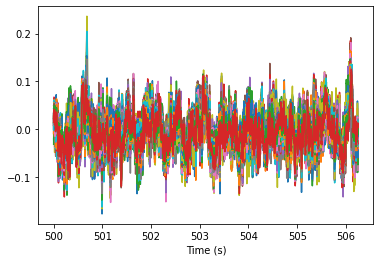

In [9]:
# ======================
# SIGNAL PARAMETERS
# ======================

# unit_indices = [0, 10, 20]
unit_indices = np.where(lfp_areas == 'vlPFC')[0]
# trajectory_start_times = np.arange(0, 7001, 500) # s
start_time = 500 # s
duration = 6.25 # s


# ------------------
# get signal
# ------------------
start_step = int(start_time/dt)
length = int(duration/dt)
lfp_pts = f['lfp'][unit_indices, start_step:start_step + length].T
var_names = [f"unit_{unit_num} {lfp_areas[unit_num]}" for unit_num in unit_indices]
time_vals = np.arange(start_time, start_time+duration, dt)

for i in range(lfp_pts.shape[1]):
    plt.plot(time_vals, lfp_pts[:, i], label=var_names[i])
plt.xlabel('Time (s)')
# plt.legend()

plt.show()

In [22]:
# ======================
# RESERVOIR PARAMETERS
# ======================

D_r = 300 # number of reservoir nodes
d = 6 # average degree of Erdos-Renyi network
p = None # probability of an edge in the Erdos-Renyi network - if not None, overrides d
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0
# beta = 1e-4 # regularization parameter
sigma = 0.1 # maximum value of the input weights
# sigma = 1/np.sqrt(2000)

squared_inds = None

In [25]:
reservoir = ReservoirDS(lfp_pts, dt=dt, D_r=D_r, d=d, p=p, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)
reservoir.train_and_test()

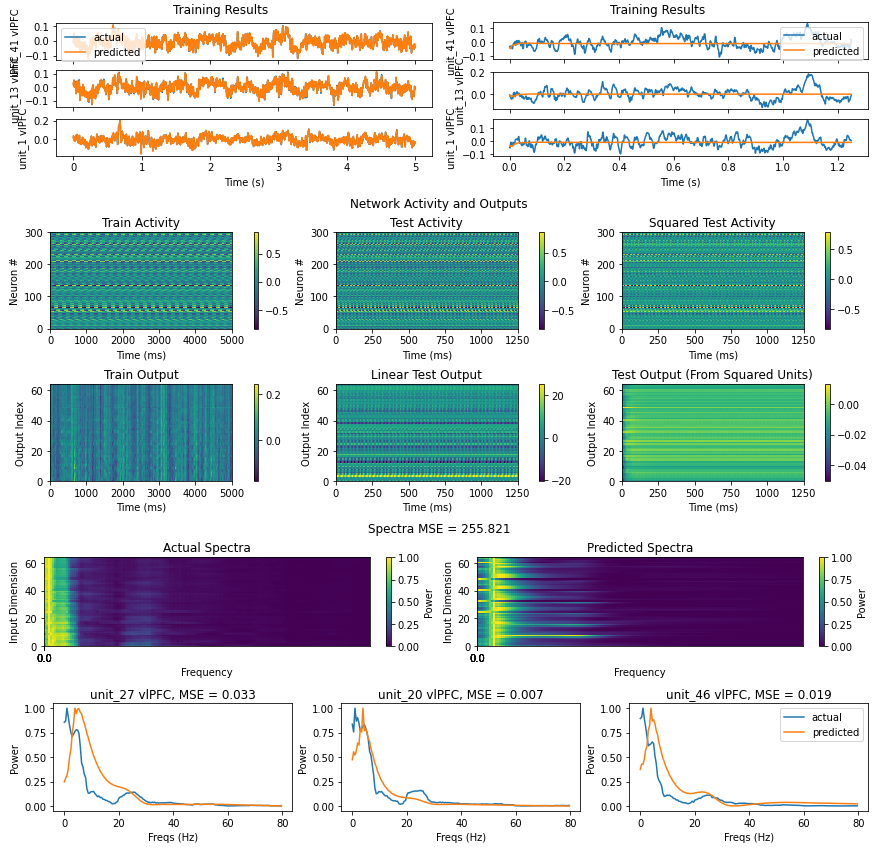

In [26]:
reservoir.plot_all()

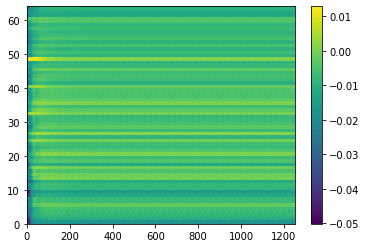

In [31]:
plt.pcolormesh(reservoir.v_test.T)
plt.colorbar()
plt.show()

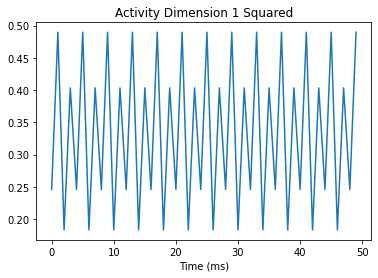

In [39]:
plt.plot(reservoir.r_test[800:850, 1]**2)
plt.title("Activity Dimension 1 Squared")
plt.xlabel("Time (ms)")
plt.show()

In [27]:
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
save(reservoir, f"../../__data__/reservoir neural data/reservoir constant {timestamp}.pkl")

In [28]:
reservoir.compute_lyap_spectrum_QR(debug=True)
reservoir.lyaps[:3]

Computing Jacobians



Performing QR decomposition...


array([-19.39276371, -20.37124427, -28.9713735 ])

In [21]:
reservoir.lyaps

array([-5.40552576e-01, -1.95040428e+01, -2.02529036e+01, -3.44434336e+01,
       -3.54399129e+01, -4.38331084e+01, -4.60350445e+01, -4.28865949e+01,
       -4.61834601e+01, -4.87224176e+01, -4.82917676e+01, -5.91504216e+01,
       -6.09218002e+01, -6.35260995e+01, -6.43925539e+01, -6.88991772e+01,
       -6.71614285e+01, -6.98838340e+01, -7.02160879e+01, -7.02324858e+01,
       -7.19100167e+01, -7.42052075e+01, -7.48308340e+01, -7.67016684e+01,
       -7.91245677e+01, -8.58382168e+01, -8.71271586e+01, -9.03764754e+01,
       -9.14621303e+01, -9.36574113e+01, -9.29621360e+01, -9.23896296e+01,
       -1.00631896e+02, -1.01404033e+02, -1.07057244e+02, -1.06139727e+02,
       -1.08920471e+02, -1.08622101e+02, -1.11634221e+02, -1.11727099e+02,
       -1.13467508e+02, -1.15060073e+02, -1.16434072e+02, -1.16205454e+02,
       -1.16891526e+02, -1.16643762e+02, -1.19535461e+02, -1.19502591e+02,
       -1.22598484e+02, -1.26808998e+02, -1.28797180e+02, -1.28348296e+02,
       -1.30076817e+02, -